In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv(r"C:\Users\hp\Downloads\diabetes.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [2]:
scaler = MinMaxScaler(feature_range=(-1, 1))

numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print(df.head())


   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.294118  0.487437       0.180328      -0.292929 -1.000000  0.001490   
1    -0.882353 -0.145729       0.081967      -0.414141 -1.000000 -0.207154   
2    -0.058824  0.839196       0.049180      -1.000000 -1.000000 -0.305514   
3    -0.882353 -0.105528       0.081967      -0.535354 -0.777778 -0.162444   
4    -1.000000  0.376884      -0.344262      -0.292929 -0.602837  0.284650   

   DiabetesPedigreeFunction       Age  Outcome  
0                 -0.531170 -0.033333      1.0  
1                 -0.766866 -0.666667     -1.0  
2                 -0.492741 -0.633333      1.0  
3                 -0.923997 -1.000000     -1.0  
4                  0.887276 -0.600000      1.0  


In [3]:
def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data < lower_bound) | (data > upper_bound))
    return outliers

numeric_columns = df.select_dtypes(include=[np.number]).columns.drop('Outcome')

outliers = {}
for column in numeric_columns:
    outliers[column] = find_outliers_iqr(df[column])
    print(f"{column}: {outliers[column].sum()} outliers")

outlier_mask = pd.DataFrame({col: outliers[col] for col in numeric_columns}).any(axis=1)

outlier_rows = df[outlier_mask]

print(f"\nTotal number of rows with outliers: {len(outlier_rows)}")

print("\nSample rows with outliers:")
print(outlier_rows.head())

Pregnancies: 4 outliers
Glucose: 5 outliers
BloodPressure: 45 outliers
SkinThickness: 1 outliers
Insulin: 34 outliers
BMI: 19 outliers
DiabetesPedigreeFunction: 29 outliers
Age: 9 outliers

Total number of rows with outliers: 129

Sample rows with outliers:
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
4     -1.000000  0.376884      -0.344262      -0.292929 -0.602837  0.284650   
7      0.176471  0.155779      -1.000000      -1.000000 -1.000000  0.052161   
8     -0.764706  0.979899       0.147541      -0.090909  0.283688 -0.090909   
9     -0.058824  0.256281       0.573770      -1.000000 -1.000000 -1.000000   
12     0.176471  0.396985       0.311475      -1.000000 -1.000000 -0.192250   

    DiabetesPedigreeFunction       Age  Outcome  
4                   0.887276 -0.600000      1.0  
7                  -0.952178 -0.733333     -1.0  
8                  -0.931682  0.066667      1.0  
9                  -0.868488  0.100000      1.0  
12               

In [4]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

numeric_columns = df.select_dtypes(include=[np.number]).columns.drop('Outcome')

df_no_outliers = remove_outliers_iqr(df, numeric_columns)

print(f"Original dataset : {df.shape}")
print(f"Dataset after removing outliers: {df_no_outliers.shape}")

retention_percentage = (len(df_no_outliers) / len(df)) * 100
print(f"Percentage of data retained: {retention_percentage:.2f}%")

print("\nFirst few rows of the cleaned dataset:")
print(df_no_outliers.head())


Original dataset : (768, 9)
Dataset after removing outliers: (636, 9)
Percentage of data retained: 82.81%

First few rows of the cleaned dataset:
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.294118  0.487437       0.180328      -0.292929 -1.000000  0.001490   
1    -0.882353 -0.145729       0.081967      -0.414141 -1.000000 -0.207154   
2    -0.058824  0.839196       0.049180      -1.000000 -1.000000 -0.305514   
3    -0.882353 -0.105528       0.081967      -0.535354 -0.777778 -0.162444   
5    -0.411765  0.165829       0.213115      -1.000000 -1.000000 -0.236960   

   DiabetesPedigreeFunction       Age  Outcome  
0                 -0.531170 -0.033333      1.0  
1                 -0.766866 -0.666667     -1.0  
2                 -0.492741 -0.633333      1.0  
3                 -0.923997 -1.000000     -1.0  
5                 -0.894962 -0.700000     -1.0  


In [5]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

perceptron = Perceptron(random_state=42, max_iter=1000, eta0 = 0.0005)
perceptron.fit(X_train_scaled, y_train)

y_pred = perceptron.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': abs(perceptron.coef_[0])})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.81      0.75      0.78        99
         1.0       0.60      0.69      0.64        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.73       154


Feature Importance:
                    Feature  Importance
1                   Glucose    0.002883
5                       BMI    0.002848
6  DiabetesPedigreeFunction    0.001645
2             BloodPressure    0.001345
3             SkinThickness    0.001044
4                   Insulin    0.000300
0               Pregnancies    0.000185
7                       Age    0.000056


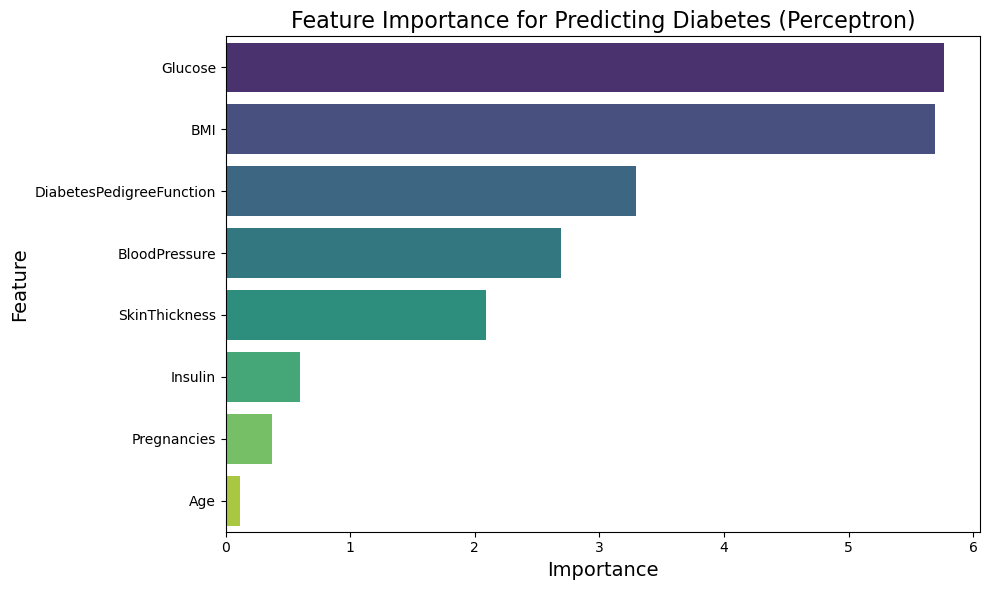

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({
    'Feature': ['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'Pregnancies', 'Age'],
    'Importance': [5.766047, 5.695416, 3.290536, 2.689770, 2.087817, 0.600014, 0.370938, 0.111231]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')

plt.title('Feature Importance for Predicting Diabetes (Perceptron)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.tight_layout()
plt.show()


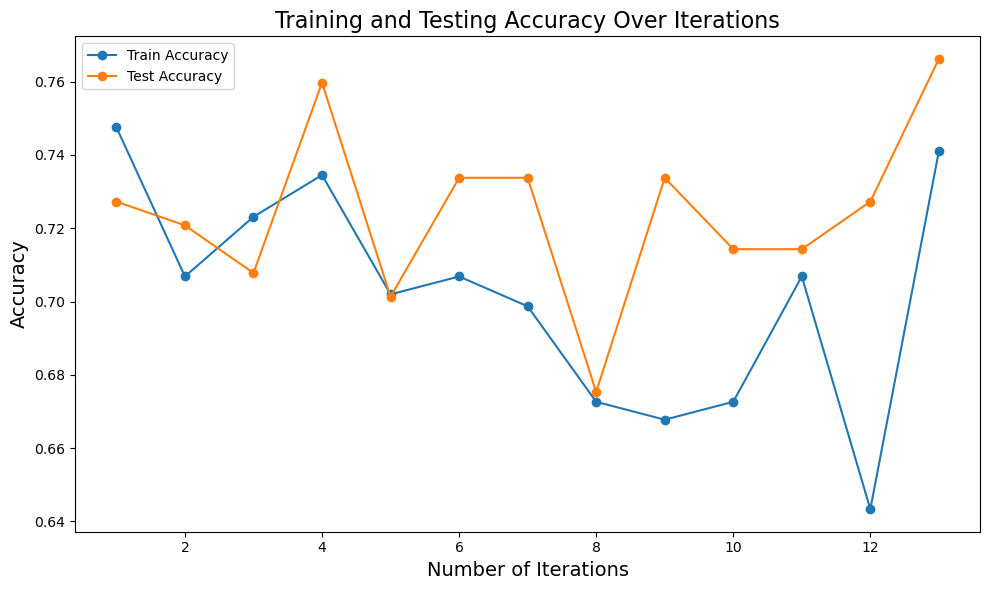

In [7]:
perceptron = Perceptron(random_state=42, max_iter=1000, eta0 = 0.0005, warm_start=True)

train_accuracies = []
test_accuracies = []

for i in range(1, 14):
    perceptron.max5_iter = i
    perceptron.fit(X_train_scaled, y_train)
    train_accuracy = accuracy_score(y_train, perceptron.predict(X_train_scaled))
    test_accuracy = accuracy_score(y_test, perceptron.predict(X_test_scaled))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 14), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, 14), test_accuracies, label='Test Accuracy', marker='o')

plt.title('Training and Testing Accuracy Over Iterations', fontsize=16)
plt.xlabel('Number of Iterations', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()